In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import plot_utils
from rl_utils import format_action, train_on_policy_agent, moving_average, \
                     normalize, update_orientation

In [2]:
class ActionSpace():
    def __init__(self, shape=[2], low=-np.pi/12, high=np.pi/12):
        self.shape = shape
        self.high = high
        self.low = low

class Environment():
    def __init__(self, state_dim, action_dim):
        #np.random.seed(12)
        self.state_dim = state_dim
        self.action_space = ActionSpace(shape=[action_dim])
        self.count = 0
        #self.death_count = max(1,int(np.random.normal(100, 10)))
        self.death_count = 100
        self.robot_orientation = np.random.uniform(-np.pi, np.pi,(1,))
        self.robot_position = np.zeros(2)
        self.robot_size = np.full((1,2), 0.1)
        self.target_zone = np.array([[9, 9], [10, 10]])
        self.forbidden_zone = np.array([[4.5, 4.5], [6.5, 6.5]]) 

    # réinitialisation de la position et de la direction du robot
    def reset(self):
        self.count = 0
        self.robot_position = np.zeros(2)
        self.robot_orientation = np.random.uniform(-np.pi, np.pi, (1,))
        #self.death_count = max(1,int(np.random.normal(100, 10)))
        self.death_count = 100
        return self.get_state()
    
    def dist_to_target(self):
        return np.linalg.norm(self.robot_position - self.target_zone.mean(axis=0))
    
    def obstacle_in_field_of_vision(self, angle_vision=np.pi/12):
        # Convertir l'orientation en vecteur directionnel
        position = self.robot_position
        orientation = self.robot_orientation[0]
        direction = np.array([np.cos(orientation),
                              np.sin(orientation)])

        # Calculer le vecteur entre la position de l'agent et le centre de l'obstacle
        vector_agent_obstacle = self.forbidden_zone.mean(axis=0) - position

        # Calculer la distance entre l'agent et le centre de l'obstacle
        distance_agent_obstacle = np.linalg.norm(vector_agent_obstacle)

        # Vérifier si l'obstacle est dans le champ de vision de l'agent
        if distance_agent_obstacle > 0:
            angle_obstacle = np.arccos(np.dot(direction, vector_agent_obstacle) / distance_agent_obstacle)
            if angle_obstacle < angle_vision:
                return 1
        return 0


    def step(self, d_orientation):

        orientation_ = self.robot_orientation + d_orientation
        if self.robot_orientation[0] + d_orientation[0] > np.pi:
            orientation_[0] = self.robot_orientation[0] + d_orientation[0] - 2*np.pi
        if self.robot_orientation[0] + d_orientation[0] < -np.pi:
            orientation_[0] = 2*np.pi + self.robot_orientation[0] + d_orientation[0]

        self.robot_orientation = orientation_
        
        self.robot_position += 1/4 * np.array([np.cos(self.robot_orientation[0]), 
                                               np.sin(self.robot_orientation[0])])

        if self.check_collision(self.robot_position): 
            return self.get_state(), -100, True  
        
        if self.check_target_reached(self.robot_position):
            return self.get_state(), 100, True  
        
        if self.is_crashed():
            return self.get_state(), -self.dist_to_target()*3, True
        
        self.count += 1
        return self.get_state(), -self.dist_to_target()/20, False

    def check_collision(self, position):
        # Vérifie si le robot est en collision avec la zone interdite
        robot_corners = self.get_robot_corners(position)
        for corner in robot_corners:
            if np.all(corner >= self.forbidden_zone[0]) and \
               np.all(corner <= self.forbidden_zone[1]):
                return True
        return False

    def get_robot_corners(self, position):
        # Retourne les coins du cube représentant le robot
        half_size = self.robot_size[0] / 2
        robot_corners = np.array([
            [position[0] - half_size, position[1] - half_size],
            [position[0] - half_size, position[1] + half_size],
            [position[0] + half_size, position[1] - half_size],
            [position[0] + half_size, position[1] + half_size]
        ])
        return robot_corners

    def check_target_reached(self, position):
        # Calcule les coordonnées du coin inférieur et du coin supérieur du cube du drone
        drone_lower_corner = position - self.robot_size[0] / 2
        drone_upper_corner = position + self.robot_size[0] / 2
    
        # Vérifie si tous les coins du cube du drone sont contenus dans la zone d'arrivée
        return (np.all(drone_lower_corner >= self.target_zone[0]) and 
                np.all(drone_upper_corner <= self.target_zone[1]))
    
    def is_crashed(self):
        return self.count == self.death_count
    
    def angle_to_target(self):
        v1 = np.array([np.cos(self.robot_orientation[0]), 
                       np.sin(self.robot_orientation[0])])
        v2 = np.array((self.target_zone[0]+self.target_zone[1])/2 - self.robot_position)
        dot_product = np.dot(v1, v2)
        norm_v1, norm_v2 = np.linalg.norm(v1), np.linalg.norm(v2)
        theta = np.arccos(dot_product / (norm_v1 * norm_v2))
        return theta

    def get_state(self):
        return np.concatenate(([self.angle_to_target()],
                               [self.dist_to_target()/20],
                               [self.obstacle_in_field_of_vision()])
                               )

In [3]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, 2*action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        middle = int(len(x[0,:])/2)
        return torch.cat((x[:,:middle], torch.nn.functional.softplus(x[:,middle:])+1e-5), dim=1)

In [4]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
class ActorCritic:
    def __init__(self, env, actor_lr, critic_lr,
                 gamma, device):

        self.action_dim = env.action_space.shape[0]
        self.state_dim = env.state_dim
        self.high_action = env.action_space.high

        self.actor = PolicyNet(self.state_dim, self.action_dim).to(device)
        self.critic = ValueNet(self.state_dim).to(device)  

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr) 
        
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state)
        action_mean = action[:, :self.action_dim] 
        action_std = action[:, self.action_dim:]
        dist = torch.distributions.Normal(action_mean, action_std)
        sampled_actions = dist.sample()
        action_f = torch.tanh(sampled_actions)*torch.tensor(self.high_action).to(self.device)
        action_f = sampled_actions.cpu().detach().numpy()[0]
        return action_f

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, self.action_dim).to(
                               self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # TD target
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)  # TD error

        action = self.actor(states)
        action_mean = action[:, :self.action_dim] 
        action_std = action[:, self.action_dim:]
        dist = torch.distributions.Normal(action_mean, action_std)

        log_probs = dist.log_prob(actions)
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        # mean square error loss function
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        
        #print(actor_loss)
        #print(critic_loss)

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # calculate the gradient of the policy network
        critic_loss.backward()  # calculate the gradient of the value network
        self.actor_optimizer.step()  # update the parameters of the policy network
        self.critic_optimizer.step()  # update the parameters of the value network

In [ ]:
actor_lr = 1e-5 #5
critic_lr = 1e-6 #6
num_episodes = 25000
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

state_dim = 3
action_dim = 1
env = Environment(state_dim, action_dim)


agent = ActorCritic(env, actor_lr, critic_lr,
                    gamma, device)

return_list = train_on_policy_agent(env, agent, num_episodes)

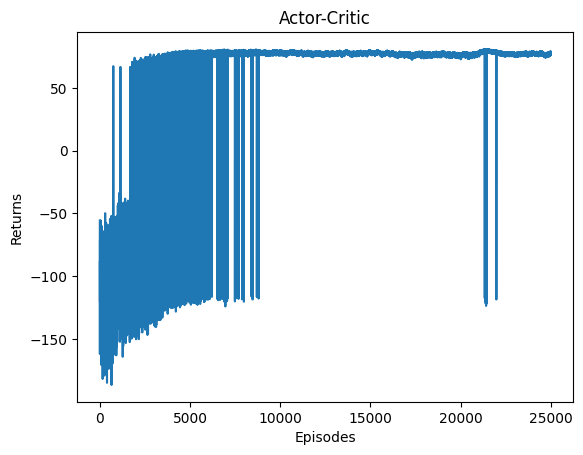

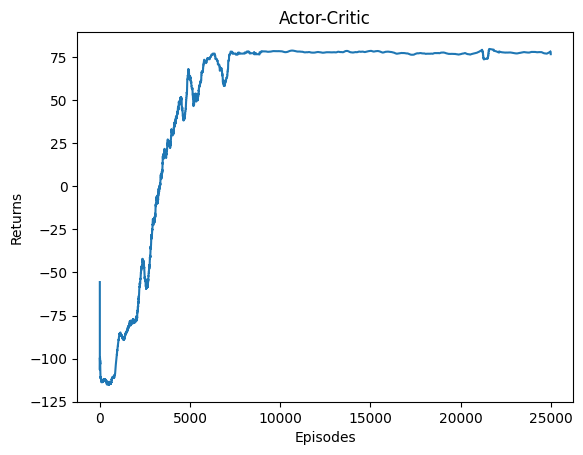

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic')
plt.show()

mv_return = moving_average(return_list, 299)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic')
plt.show()